In [1]:
# This notebook replicates McGill-van Ryzin 2000 Management Science Article

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [3]:
# Test problem scenarios: four classes with different fares and demand statistics
n_class = 4
fare = np.array([1050, 567, 527, 350])
mean = np.array([17.3, 45.1, 73.6, 19.8])
std = np.array([5.8, 15.0, 17.4, 6.6])

In [4]:
mean_cumsum = np.cumsum(mean)
std_cumsum = np.sqrt(np.cumsum(std**2))
totalrev = fare * mean
totalrev_cumsum = np.cumsum(totalrev)

In [5]:
(mean_cumsum, std_cumsum, totalrev, totalrev_cumsum)

(array([ 17.3,  62.4, 136. , 155.8]),
 array([ 5.8       , 16.08228839, 23.69388107, 24.59593462]),
 array([18165. , 25571.7, 38787.2,  6930. ]),
 array([18165. , 43736.7, 82523.9, 89453.9]))

In [6]:
# Compute weighted average revenue
avgrev_weighted = totalrev_cumsum / mean_cumsum
# Probability of demand being higher than the protection level
prob_emsr = np.array([fare[i+1] / avgrev_weighted[i] for i in range(n_class - 1)])

In [7]:
avgrev_weighted, prob_emsr

(array([1050.        ,  700.90865385,  606.79338235,  574.15853659]),
 array([0.54      , 0.75188114, 0.5768026 ]))

In [8]:
# EMSR-b protection levels
theta_emsr = st.norm.ppf(1 - prob_emsr, mean_cumsum[:-1], std_cumsum[:-1])

In [9]:
theta_emsr

array([ 16.71748442,  51.4572678 , 131.41001141])

In [10]:
# Calculate optimal protection level based on stochastic approximation (SA)
ratio = np.array([fare[i] / fare[0] for i in range(1, n_class)])

In [11]:
# In order to find optimal protection levels for SA algorithm, we use
# monte carlo integration specified in McGill-van Ryzin(2004) book
# Page 43
size = 100000
# Normal dist
demand = np.array([np.random.normal(mean[i], std[i], size) for i in range(n_class)])

# Lognormal dist
# Be careful when calculating parameters: https://en.wikipedia.org/wiki/Log-normal_distribution
# logmean = np.log(mean**2 / np.sqrt(mean**2 + std**2))
# logstd = np.sqrt(np.log(1 + std**2 / mean**2))
# demand = np.array([np.random.lognormal(logmean[i], logstd[i], size=size) for i in range(n_class)])

demand = np.transpose(demand)

In [12]:
demand[:10,]

array([[31.57075521, 44.2754519 , 88.40516361,  6.59527285],
       [15.02709161, 44.57180409, 77.71735304, 17.09794097],
       [13.28667021, 44.99522037, 72.5070114 , 19.39906784],
       [15.48570594, 47.60621413, 93.05159951,  5.93997117],
       [22.67009894, 38.33478507, 64.05475001, 27.08362691],
       [21.77795698, 56.68841881, 76.87114012, 21.80911104],
       [13.20751624, 40.2496485 , 57.93685133, 13.71133715],
       [12.43544978, 24.74252044, 96.08788417, 23.0799683 ],
       [ 5.38434199, 73.724113  , 55.6266903 , 14.07543043],
       [ 6.54165204, 39.29418687, 94.1308385 , 20.52791147]])

In [13]:
# Compute random demand partial sums
demand_cumsum = np.array([np.cumsum(demand[i]) for i in range(size)])
demand_cumsum[:10]

array([[ 31.57075521,  75.84620711, 164.25137072, 170.84664356],
       [ 15.02709161,  59.5988957 , 137.31624874, 154.41418971],
       [ 13.28667021,  58.28189059, 130.78890199, 150.18796983],
       [ 15.48570594,  63.09192007, 156.14351958, 162.08349076],
       [ 22.67009894,  61.004884  , 125.05963401, 152.14326092],
       [ 21.77795698,  78.46637579, 155.33751591, 177.14662696],
       [ 13.20751624,  53.45716474, 111.39401606, 125.10535321],
       [ 12.43544978,  37.17797022, 133.26585439, 156.34582268],
       [  5.38434199,  79.10845499, 134.73514529, 148.81057572],
       [  6.54165204,  45.83583891, 139.96667741, 160.49458888]])

In [14]:
theta_norm = []
cumsum_copy = demand_cumsum.copy()
for j in range(n_class - 1):
    # Step 1
    cumsum_copy_ordered = np.sort(cumsum_copy[:, j])
    # Step 2
    threshold = int(np.floor((fare[j+1] / fare[j]) * len(cumsum_copy_ordered)))
    # An error in the initial algorithm. After calculation l*, there should be
    # one more calculation before finding y_j, which is the index used to calculate
    # y_j should be |k|-l*, not l* itself.
    threshold = len(cumsum_copy_ordered) - threshold
    theta = 0.5 * (cumsum_copy_ordered[threshold-1] + cumsum_copy_ordered[threshold])
    # Step 3
    index = np.where(cumsum_copy[:, j] > theta)
    # In step 3, we only keep the updated values we use for next iteration
    cumsum_copy = cumsum_copy[index]
    theta_norm.append(theta)

In [15]:
theta_norm

[16.711870768473116, 43.99051593695084, 132.67582790766411]

In [16]:
# Algorithm starting protection levels
theta_low = np.array([0, 15, 65])
theta_high = np.array([35, 110, 210])
expected_demand = np.sum(mean)
cap_low = 124
cap_high = 164

# For SA algorithm, we have two parameters for step size: param1 and param2
param1, param2 = 200, 10

# Calculate load factors
load_high = expected_demand / cap_low
load_low = expected_demand / cap_high
print("%.2f" % load_high, "%.2f" % load_low)

1.26 0.95


In [17]:
# For the remainder of the simulation, assume normal distribution
flights = 100
n_simulation = 64
thetas = []
for _ in range(n_simulation):
    theta_update = theta_low
    capacity = cap_low
    for flight in range(flights):
        obs_demand = np.array([np.random.normal(mean[i], std[i], 1) for i in range(n_class)])
        obs_demand_cumsum = np.cumsum(obs_demand)
        # Compute if the demand for a class exceeds its corresponding protection levels 
        Y = np.array([1 if obs_demand_cumsum[i] > theta_update[i] else 0 for i in range(n_class - 1)])
        # Implement Equation(2) in vanRyzin-McGill 2000
        Z = np.cumprod(Y)
        # Calculate H(theta, x)
        H = ratio - Z
        theta_update = theta_update - (param1 / (param2+flight)) * H
        # Capacity constraint and nonnegativity for protection levels
        theta_update = np.minimum(theta_update, np.repeat(capacity, n_class - 1))
        theta_update = np.maximum(theta_update, np.zeros(n_class - 1))
        thetas.append(theta_update)

thetas = np.array(thetas).reshape(n_simulation, flights, n_class - 1)

In [18]:
thetas_avg = np.mean(thetas, axis = 0)

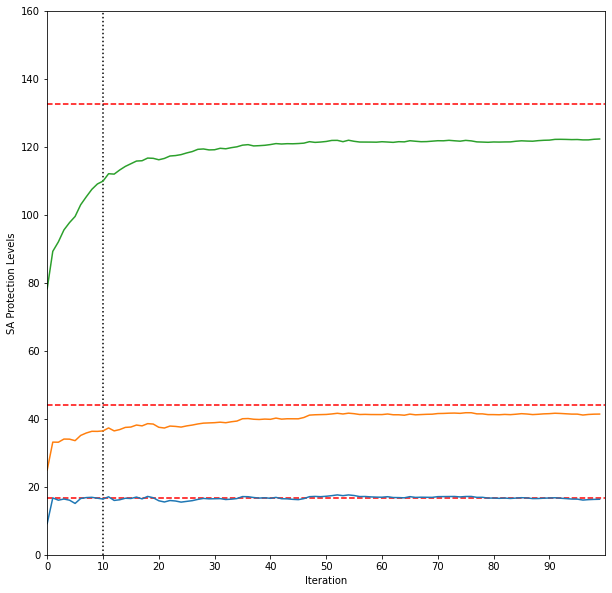

In [33]:
plt.figure(figsize=(10, 10))
plt.plot(thetas_avg)
plt.hlines(theta_norm, xmin = 0, xmax = 100, ls='dashed', color='r')
plt.axis([0, 100, 0, 160])
plt.xlabel('Iteration')
plt.ylabel('SA Protection Levels')
plt.xticks(np.arange(0, 100, step=10))
plt.vlines(10, ymin=0, ymax=160, ls='dotted')
plt.show()